# DICOM Image Segmentation

**Author:** Dragos Ghinoiu

## Extract the data

We'll focus for now on analysing only the input data from the 'input' folder.

In [3]:
import os
import numpy as np
import cv2 as cv

data_base_path = "/home/dragoshh1984/apllications/problem_data"
input1_path = os.path.join(data_base_path, 'input1')

dicom_image_path = os.path.join(input1_path, '107-HU.in')
dicom_image = np.loadtxt(dicom_image_path, dtype=np.float32)

seg_image_path = os.path.join(input1_path, '107-seg.in')
seg_image = np.loadtxt(seg_image_path, dtype=np.float32)

expected_result_path = os.path.join(input1_path, '107-opt.out')
expected_result = np.loadtxt(expected_result_path, dtype=np.float32)

## DICOM Image visualization

Let's plot the data so we can have a better understanding of it.
To do so we'll define some utility functions for processing and plotting the image.

In [4]:
import matplotlib.pyplot as plt

def preprocess_dicom_image(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def plot_image(image, title='DICOM Image'):
    image_height, image_width = image.shape
    
    fig, ax = plt.subplots(1, 1)
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
    plt.show()
    plt.imsave("{}.png".format(title), image, cmap='gray')

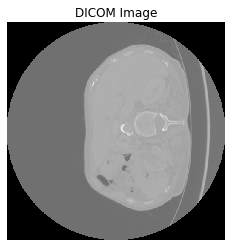

In [5]:
dicom_image_preprocessed = preprocess_dicom_image(dicom_image)
plot_image(dicom_image_preprocessed)

## DICOM Image processing

Let's plot the histogram of the DICOM image

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


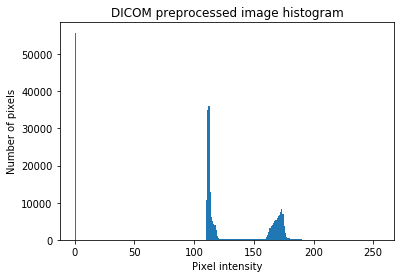

In [6]:
print(dicom_image_preprocessed)

dicom_image_preprocessed *= 255

hist = plt.hist(dicom_image_preprocessed.ravel(), bins=255)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('DICOM preprocessed image histogram')

plt.savefig("histogram_DICOM.png")
plt.show()

Next we propose to remove some unecessary information (the grey circle around the organ) by histogram equalization.

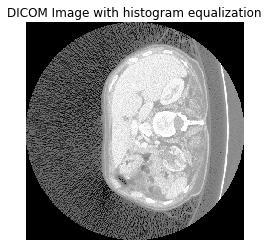

In [7]:
dicom_image_processed = dicom_image_preprocessed.copy().astype(np.uint8)
dicom_image_processed = cv.equalizeHist(dicom_image_processed)
plot_image(dicom_image_processed, title='DICOM Image with histogram equalization')

Let's try another method instead.

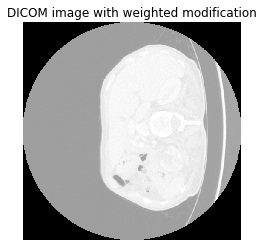

In [8]:
alpha = 1.2
beta = 40

dicom_image_processed = dicom_image_preprocessed.copy().astype(np.uint8)
dicom_image_processed = cv.addWeighted(dicom_image_processed, 
                                       alpha, 
                                       np.zeros(dicom_image_processed.shape, dicom_image_processed.dtype), 
                                       0, 
                                       beta)
plot_image(dicom_image_processed, title="DICOM image with weighted modification")

We'll now try a more trivial method: adjusting the pixel values by the mean of the pixels, 
because it seems that the grey circle has about the mean value (~127).

In order to avoid the magical number, we'll extract the mean of the pixel values.

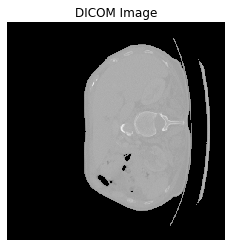

In [9]:
dicom_image_processed = dicom_image_preprocessed.copy().astype(np.uint8)
dicom_image_processed[dicom_image_processed < 127] = 0
# dicom_image_processed[dicom_image_processed < 0] = 0

plot_image(dicom_image_processed)


We'll use this image from now on.

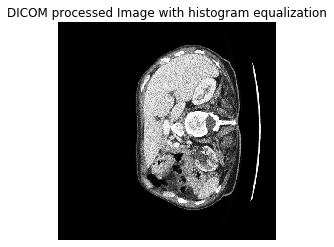

In [10]:
dicom_image_eq_hist = cv.equalizeHist(dicom_image_processed)
plot_image(dicom_image_eq_hist, title='DICOM processed Image with histogram equalization')

Let's get rid of the noise using a median/gaussian filter.

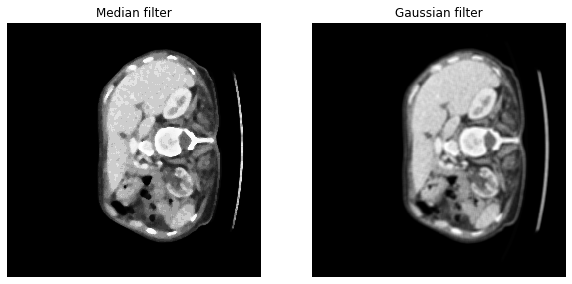

In [11]:
dicom_image_median_noise_reduction = dicom_image_eq_hist.copy()
dicom_image_gaussian_noise_reduction = dicom_image_eq_hist.copy()

dicom_image_median_noise_reduction = cv.medianBlur(dicom_image_median_noise_reduction, 7)
dicom_image_gaussian_noise_reduction = cv.GaussianBlur(dicom_image_gaussian_noise_reduction, (7,7), 5)

fig = plt.figure(figsize=(10,10))

fig.add_subplot(1, 2, 1)
plt.imshow(dicom_image_median_noise_reduction,cmap='gray')
plt.axis('off')
plt.title('Median filter')

fig.add_subplot(1, 2, 2)
plt.imshow(dicom_image_gaussian_noise_reduction, cmap='gray')
plt.axis('off')
plt.title('Gaussian filter')

plt.savefig("Median_vs_Gaussian_blur.png")
plt.show()

Simple filtering like this isn't going to help. Next we'll try a denoising technique called Non-Local Means Denoising.

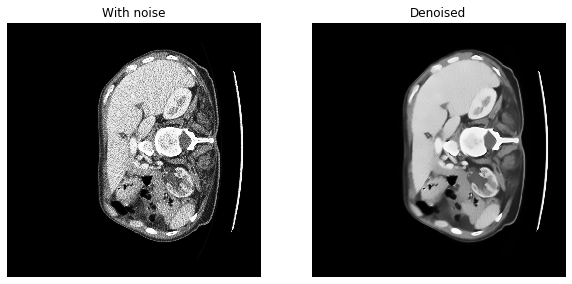

In [12]:
dicom_image_denoised = dicom_image_eq_hist.copy()
dicom_image_denoised = cv.fastNlMeansDenoising(dicom_image_denoised, None, 30, 7, 21)

fig = plt.figure(figsize=(10,10))

fig.add_subplot(1, 2, 1)
plt.imshow(dicom_image_eq_hist, cmap='gray')
plt.axis('off')
plt.title('With noise')

fig.add_subplot(1, 2, 2)
plt.imshow(dicom_image_denoised, cmap='gray')
plt.axis('off')
plt.title('Denoised')

plt.savefig("Denoised_image.png")
plt.show()

## Image Segmentation

We'll try to region growing on our denoised version of the DICOM image.

We'll apply some threshold in order to obtain a partial segmentation of our desired organ.

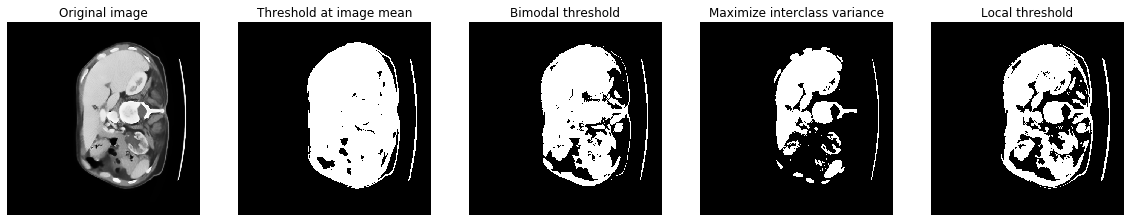

In [13]:
from skimage.filters import threshold_minimum
from skimage.filters import threshold_otsu
from skimage.filters import threshold_mean
from skimage.filters import threshold_local

dicom_image_processed = dicom_image_denoised.copy()

thresh_mean = threshold_mean(dicom_image_processed)
binary_mean = dicom_image_processed > thresh_mean

thresh_otsu = threshold_otsu(dicom_image_processed)
binary_otsu = dicom_image_processed > thresh_otsu

thresh_min = threshold_minimum(dicom_image_processed)
binary_min = dicom_image_processed > thresh_min

thresh_local = threshold_local(dicom_image_processed, 157)
binary_local = dicom_image_processed > thresh_local

plt.figure(figsize=(20, 4.5))

plt.subplot(151)
plt.imshow(dicom_image_denoised, cmap='gray')
plt.title('Original image')
plt.axis('off')

plt.subplot(152)
plt.imshow(binary_mean, cmap='gray')
plt.title('Threshold at image mean')
plt.axis('off')

plt.subplot(153)
plt.imshow(binary_otsu, cmap='gray')
plt.title('Bimodal threshold')
plt.axis('off')

plt.subplot(154)
plt.imshow(binary_min, cmap='gray')
plt.title('Maximize interclass variance')
plt.axis('off')

plt.subplot(155)
plt.imshow(binary_local, cmap='gray')
plt.title('Local threshold')
plt.axis('off')

plt.savefig("Thresholds_DICOM_img.png")
plt.show()

# ret, thresh = cv.threshold(dicom_image_processed, 192, 255, cv.THRESH_BINARY)

# plot_image(thresh, title='DICOM with threshold')

Because for now we are not interested in other regions, but only in the one selected by the doctor, we should implement a threshold that sets apart that region.

201


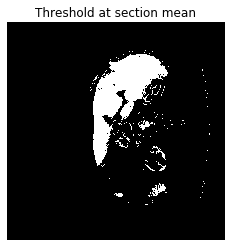

In [14]:
decent_threshold = np.uint8(np.mean(dicom_image_processed[seg_image == 1]))
print(decent_threshold)

def apply_threshold(image, low, up):
    return (image > low) & (image < up)

dicom_image_thresh = apply_threshold(dicom_image_processed, decent_threshold-10, decent_threshold+15)

plot_image(dicom_image_thresh, title="Threshold at section mean")

We'll use this version of the image for a first working solution, where we'll further apply region growing.

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


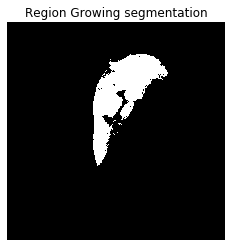

In [15]:
from scipy.ndimage import morphology
from scipy.ndimage import sobel
from skimage import measure
# from skimage.morphology import erosion, square

def get_contained_pixel(image):
    image = cv.erode(image, None, iterations=10)
    xy_pixel = np.where(image==1)
    
    return xy_pixel[0][int(len(xy_pixel[0])/2)], xy_pixel[1][int(len(xy_pixel[0])/2)]

x_pixel, y_pixel = get_contained_pixel(seg_image)
# print(x_pixel, y_pixel)
segments = measure.label(dicom_image_thresh)
segments = segments == segments[x_pixel][y_pixel]
print(segments)
plot_image(segments, title='Region Growing segmentation')

As we've isolated the approximate section of the organ, we proceed to fill the image using a closing operator.

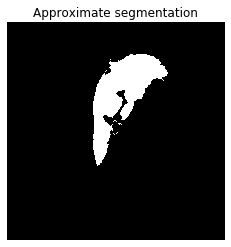

In [16]:
segment_closed = morphology.binary_closing(segments, iterations=2)

plot_image(segment_closed, "Approximate segmentation")

We'll get rid of the small white noise in the image. For that we can use morphological opening.

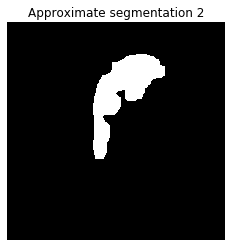

In [17]:
segment_closed_opening = segment_closed.copy().astype(np.uint8)

segment_closed_opening = cv.morphologyEx(segment_closed.astype(np.uint8),
                                         cv.MORPH_OPEN, kernel=np.ones((3,3),np.uint8), 
                                         iterations=9)

plot_image(segment_closed_opening, title='Approximate segmentation 2')

segment_closed = segment_closed_opening

# Fine tuning segmentation

First method that we'll try involves active contours/contour finding.

/home/dragoshh1984/anaconda3/envs/dicom_env/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.


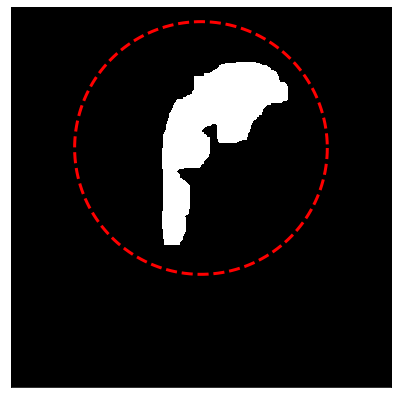

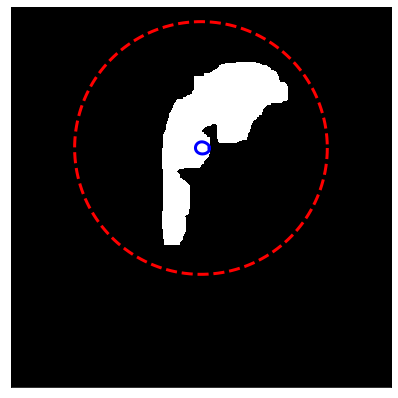

In [18]:
from skimage.segmentation import active_contour

organ_section = segment_closed.copy()

# we must create a circle around the section
s = np.linspace(0, 2*np.pi, 512)
x = 256 + 170 * np.cos(s)
y = 190 + 170 * np.sin(s)
circle = np.array([x, y]).T

# now we reduce that circle towards the contour of the section
contour_section = active_contour(organ_section,
                                 circle, 
                                 alpha=0.55,
                                 beta=100, 
                                 gamma=0.011,
                                 w_line=0.5,
                                 w_edge=1)

fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(111)
plt.gray()
ax.imshow(organ_section)

ax.plot(circle[:, 0], circle[:, 1], '--r', lw=3)

ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, organ_section.shape[1], organ_section.shape[0], 0])

fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(111)
plt.gray()
ax.imshow(organ_section)

ax.plot(circle[:, 0], circle[:, 1], '--r', lw=3)
ax.plot(contour_section[:, 0], contour_section[:, 1], '-b', lw=3)

ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, organ_section.shape[1], organ_section.shape[0], 0])

plt.show()

As far as I've observed this continuation won't get us anywhere.
We'll try smoothen the edges for now.

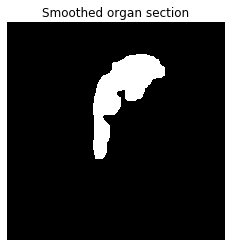

In [19]:
from scipy.signal import medfilt

organ_section_smoothed = medfilt(organ_section, 5)

plot_image(organ_section_smoothed, "Smoothed organ section")

# Evaluation



In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

def print_metrics(output, truth):
    output = output.flatten()
    truth = truth.flatten()
    
    print("Precision: {}".format(precision_score(output, truth)))
    print("Recall: {}".format(recall_score(output, truth)))
    print("F1-score: {}".format(f1_score(output, truth)))

print_metrics(organ_section_smoothed, expected_result)

Precision: 0.8990319614947813
Recall: 0.9632076018309288
F1-score: 0.930013986013986


# Watershed Method

We need to separate sure background, sure foreground and unknown area.

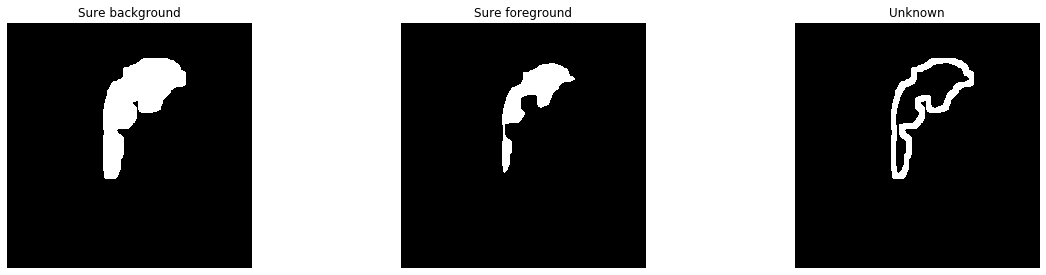

In [21]:
organ_section = organ_section_smoothed.copy().astype(np.uint8)
organ_section *= 255

sure_bg = cv.dilate(organ_section, kernel=np.ones((3,3), np.uint8), iterations=3)

# distance transform tends to shrink too much thin areas
# dist_transform = cv.distanceTransform(organ_section, cv.DIST_C, 3)
# ret, sure_fg = cv.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

sure_fg = cv.erode(organ_section, kernel=np.ones((3,3),np.uint8), iterations=8)

sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)

plt.figure(figsize=(20, 4.5))

plt.subplot(131)
plt.imshow(sure_bg, cmap='gray')
plt.title('Sure background')
plt.axis('off')

plt.subplot(132)
plt.imshow(sure_fg, cmap='gray')
plt.title('Sure foreground')
plt.axis('off')

plt.subplot(133)
plt.imshow(unknown, cmap='gray')
plt.title('Unknown')
plt.axis('off')

plt.savefig("Watershed preprocessing")

# plot_image(sure_bg, title='Sure background')
# plot_image(sure_fg, title='Sure foreground')

[  0 255]
[0 1 2]


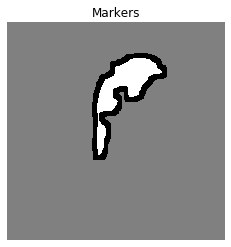

In [194]:
markers = None
ret, markers = cv.connectedComponents(sure_fg)
markers += 1
print(np.unique(unknown))
markers[unknown==255] = 0
print(np.unique(markers))

plot_image(markers, title='Markers')

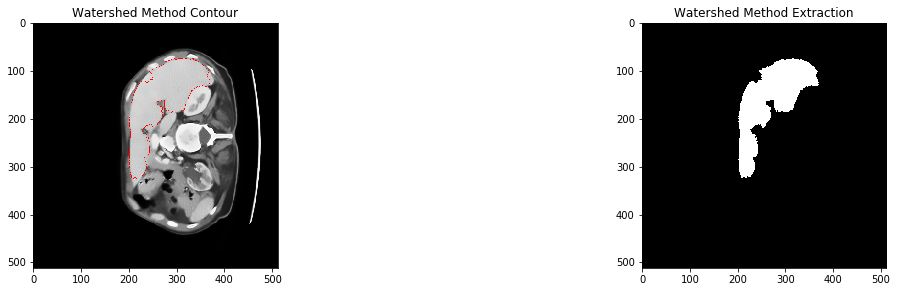

In [195]:
# dicom_image_processed
# print(np.unique(dicom_image_processed))

watershed_image = cv.merge((dicom_image_processed, dicom_image_processed, dicom_image_processed))
markers = cv.watershed(watershed_image, markers)

watershed_image[markers==-1] = [255, 0, 0]
markers[markers==-1] = 1

plt.figure(figsize=(20, 4.5))

plt.subplot(121)
plt.imshow(watershed_image, cmap='gray')
plt.title("Watershed Method Contour")
plt.imsave("watershed_method.png", watershed_image)

plt.subplot(122)
plt.imshow(markers, cmap='gray')
plt.title("Watershed Method Extraction")
plt.imsave("watershed_method_extraction.png", markers)

plt.savefig("Watershed Method")

plt.show()

Let's evaluate this method's solution after rounding the edges.

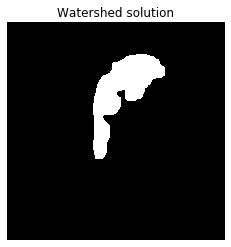

In [192]:
watershed_section = markers.copy().astype(np.uint8)
watershed_section = medfilt(organ_section, 5)
watershed_section[watershed_section==255.] = 1.

plot_image(watershed_section, "Watershed solution")

In [193]:
print_metrics(watershed_section, expected_result)

Precision: 0.8990319614947813
Recall: 0.9635425723062656
F1-score: 0.9301700984780662


## Contour detection

As we can see, because the contours aren't very clearly separable, the marching squares algorithm won't produce very good results straight away.

Another reason why it isn't so good is that is highly dependable on the threshold.

We'll try different contours approaches.

(-0.5, 511.5, 511.5, -0.5)

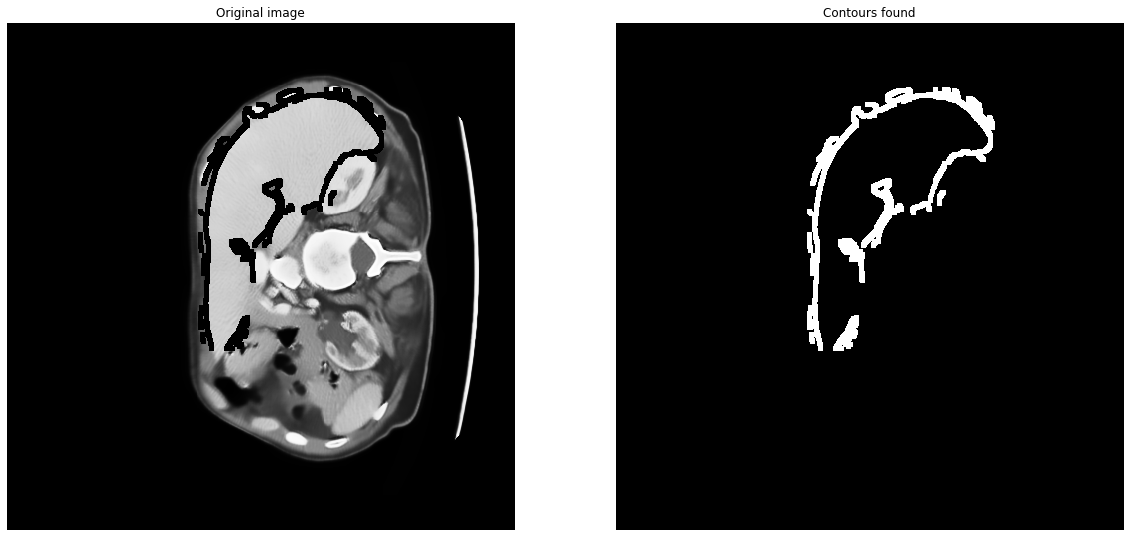

In [292]:
from skimage import feature

dicom_image = dicom_image_denoised.copy()

# dicom_contours = cv.Canny(dicom_image, decent_threshold-20, decent_threshold+20)
# laplacian = cv.Laplacian(dicom_image, cv.CV_64F)
# sobel = cv.Sobel(dicom_image, cv.CV_64F, 1, 1, ksize=5)

dicom_image_copy = dicom_image.copy()
canny_mask = cv.dilate(organ_section, kernel=np.ones((3,3), np.uint8), iterations=9)

dicom_contours = feature.canny(dicom_image, sigma=1, mask=canny_mask.astype(np.bool))
# dicom_contours = dicom_contours.astype(np.uint8) * 255

# dicom_points = np.argwhere(dicom_contours==255)

# print(dicom_points[:,1])
# dicom_points[:, 0], dicom_points[:, 1] = dicom_points[:, 1], dicom_points[:, 0].copy()
# print(dicom_points[:,1])

# dicom_points = dicom_points.reshape(-1, 1, 2)

# contours_closed = cv.polylines(dicom_image_copy, 
#                                [dicom_points], 
#                                isClosed=True,
#                                color=255,
#                                thickness=1, 
#                                lineType=8, 
#                                shift=0)

dicom_contours = cv.dilate(dicom_contours.astype(np.uint8), kernel=np.ones((3,3), np.uint8), iterations=2)

dicom_image_copy[dicom_contours==1] = 0

plt.figure(figsize=(20, 20))

plt.subplot(121)
plt.imshow(dicom_image_copy, cmap='gray')
plt.title('Original image')
plt.axis('off')

plt.subplot(122)
plt.imshow(dicom_contours, cmap='gray')
plt.title('Contours found')
plt.axis('off')

# plt.subplot(143)
# plt.imshow(laplacian, cmap='gray')
# plt.title('Laplacian')
# plt.axis('off')

# plt.subplot(144)
# plt.imshow(sobel, cmap='gray')
# plt.title('Sobel')
# plt.axis('off')


We'll use a marching square algorithm provided by skimage.measure.find_contour to find all the contours. We'll aply this to the above image.

159


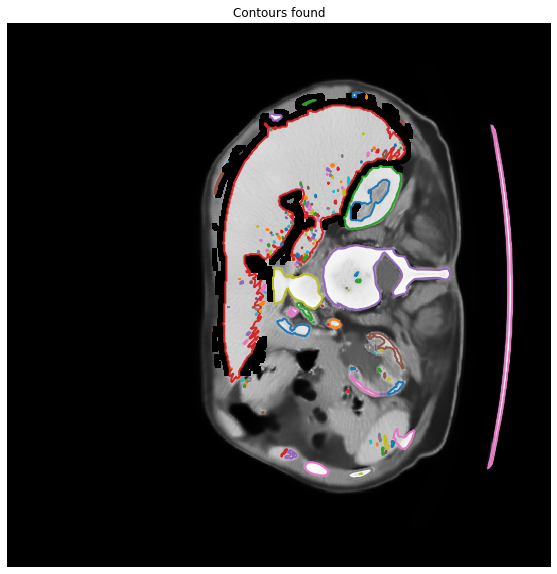

In [641]:
dicom_image = dicom_image_copy.copy()
# dicom_image = dicom_image_eq_hist.copy()

decent_threshold = np.uint8(np.mean(dicom_image_processed[seg_image == 1]))
# print(decent_threshold)
contours = measure.find_contours(dicom_image, 
                                 decent_threshold-4, 
                                 fully_connected='high',
                                 positive_orientation='low')

print(len(contours))

plt.figure(figsize=(10, 10))
plt.imshow(dicom_image, cmap='gray')
for _, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
plt.title('Contours found')
plt.axis('off')

plt.show()
# print(contours)

First we have to choose the contour.

In [294]:
from scipy import ndimage

def fill_contour(image):
    image_filled = image.copy()
    image_filled = ndimage.morphology.binary_dilation(image_filled, None, 3)
    image_filled = ndimage.binary_fill_holes(image_filled, structure=np.ones((3,3)))
#     image_filled = ndimage.morphology.binary_closing(image_filled, None, 3)
    
    return image_filled

filled_contours = []

for index, contour in enumerate(contours):
    new_image = np.zeros((512, 512), dtype=np.uint8)
    
    for pixel in contour:
        new_image[int(pixel[0]), int(pixel[1])] = 1
    
    new_image = fill_contour(new_image)
    
    filled_contours.append(new_image)
    

In [295]:
def get_area(image):
    return len(image[image==1])

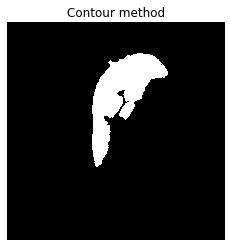

In [296]:
chosen_contours = []
chosen_contours_areas = []

doctor_area = get_area(seg_image)

for contour in filled_contours:
    current_area = get_area(contour)
    
    if current_area < 2 * doctor_area and current_area > (2 * doctor_area) / 3:
        chosen_contours.append(contour)
        chosen_contours_areas.append(current_area)

best_contour = contours[0]
best_intersection = 0

for contour in chosen_contours:
    intersection = get_area((seg_image.astype(np.uint8) & contour.astype(np.uint8)))
    
    if best_intersection < intersection:
        best_contour = contour
        best_intersection = intersection

plot_image(best_contour, title='Contour method')

## Seems a bit forced of a method, but if it works, it's ok.

(-0.5, 511.5, 511.5, -0.5)

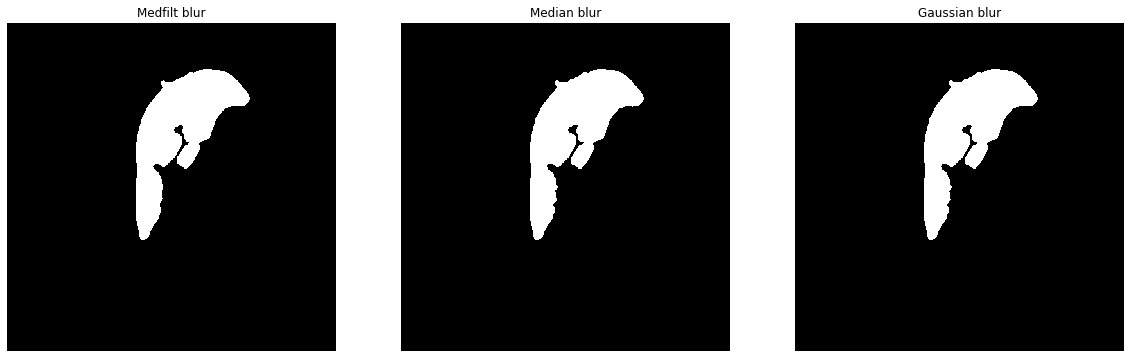

In [297]:
best_contour_smooth = medfilt(best_contour.astype(np.uint8), 7)
# best_contour_smooth = medfilt(best_contour_smooth, 7)

for _ in range(0, 10):
    best_contour_median_blured = cv.medianBlur(best_contour.astype(np.uint8), 5)

best_contour_gaussian_blured = cv.GaussianBlur(best_contour.astype(np.uint8), (11,11), 0)
    
plt.figure(figsize=(20, 20))

plt.subplot(131)
plt.imshow(best_contour_smooth, cmap='gray')
plt.title('Medfilt blur')
plt.axis('off')

plt.subplot(132)
plt.imshow(best_contour_median_blured, cmap='gray')
plt.title('Median blur')
plt.axis('off')

plt.subplot(133)
plt.imshow(best_contour_gaussian_blured, cmap='gray')
plt.title('Gaussian blur')
plt.axis('off')


Let's have a look at how our contour differs from the doctor's on the original image.

(-0.5, 511.5, 511.5, -0.5)

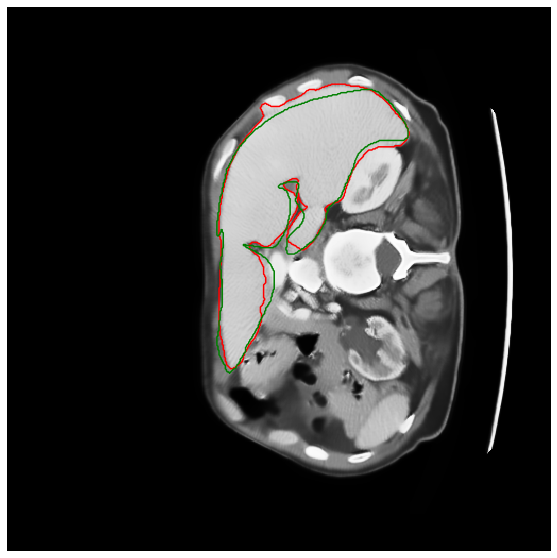

In [321]:
non


## Superpixel method

[[   0    0    0 ...  101  101  101]
 [   0    0    0 ...  101  101  101]
 [   0    0    0 ...  101  101  101]
 ...
 [9861 9861 9861 ... 9962 9962 9962]
 [9861 9861 9861 ... 9962 9962 9962]
 [9861 9861 9861 ... 9962 9962 9962]]


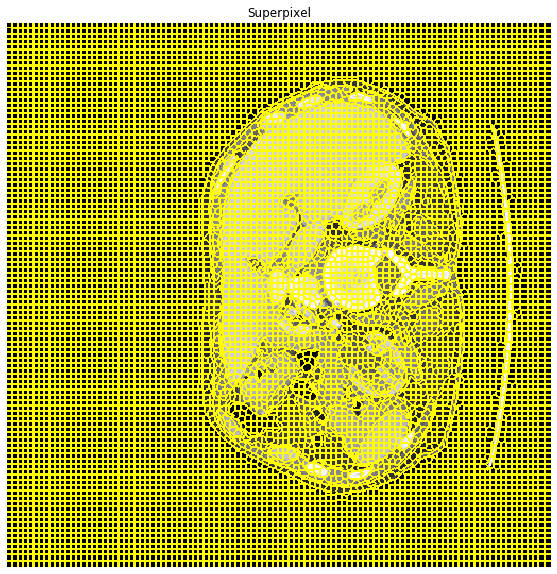

In [650]:
from skimage import segmentation, color

dicom_image_superpixel = cv.merge((dicom_image_processed, dicom_image_processed, dicom_image_processed))

no_labels = 9000

dicom_segments = segmentation.slic(dicom_image_superpixel,
                                   compactness=9,
                                   n_segments=no_labels)


superpixels = color.label2rgb(dicom_segments, dicom_image_processed, kind='avg')

print(dicom_segments)

plt.figure(figsize=(10, 10))

# for segment in dicom_segments:
#     plt.plot(segment)

# superpixels[dicom_segments==84] = 0

plt.imshow(segmentation.mark_boundaries(dicom_image_processed, dicom_segments))
plt.axis('off')
plt.title('Superpixel')

plt.show()

Now we must select the segments labels which are close to the doctor's selection.

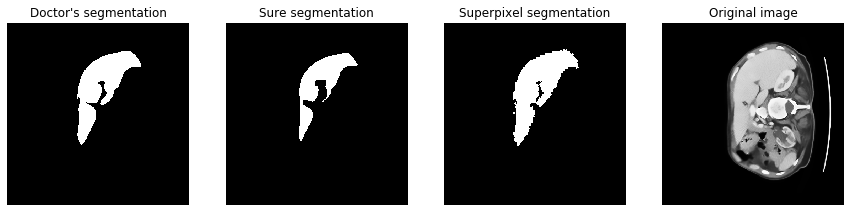

In [651]:
labels_inside = np.zeros(no_labels)

sure_segmentation = cv.erode(seg_image.copy(), None, iterations=5)

for label in range(0, no_labels):
    current_label_inside_area = np.count_nonzero(seg_image[dicom_segments==label] == 1)
    total_label_area = len(dicom_segments[dicom_segments==label])
    
    if total_label_area > 0 and current_label_inside_area / total_label_area > 0.15:
        labels_inside[label] = 1

new_segmentation = np.zeros((512, 512), dtype=np.uint8)

for label, inside_status in enumerate(labels_inside):
    if inside_status == 1:
        new_segmentation[dicom_segments==label] = 1

plt.figure(figsize=(15, 15))

plt.subplot(141)
plt.imshow(seg_image, cmap='gray')
plt.title('Doctor\'s segmentation')
plt.axis('off')

plt.subplot(142)
plt.imshow(sure_segmentation, cmap='gray')
plt.title('Sure segmentation')
plt.axis('off')

plt.subplot(143)
plt.imshow(new_segmentation, cmap='gray')
plt.title('Superpixel segmentation')
plt.axis('off')

plt.subplot(144)
plt.imshow(dicom_image_processed, cmap='gray')
plt.title('Original image')
plt.axis('off')

plt.show()

This method needs further analysis; as for now we won't try to implement it because its parameters need too much tweaking for actual decent results which depends on the case at hand.